
Inertia Details

Rocket Mass: 35.969 kg (without motor)
Rocket Dry Mass: 61.069 kg (with unloaded motor)
Rocket Loaded Mass: 86.089 kg
Rocket Structural Mass Ratio: 0.709
Rocket Inertia (with unloaded motor) 11: 72.792 kg*m2
Rocket Inertia (with unloaded motor) 22: 72.792 kg*m2
Rocket Inertia (with unloaded motor) 33: 1.640 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.1 m
Rocket Frontal Area: 0.031416 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.181 m
Rocket Center of Dry Mass - Nozzle Exit: 1.589 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.249 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.072 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 8.129/rad
Tail Lift Coefficient Der

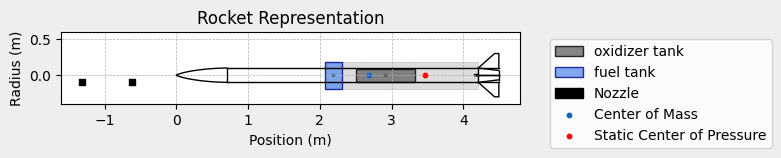


Mass Plots
----------------------------------------


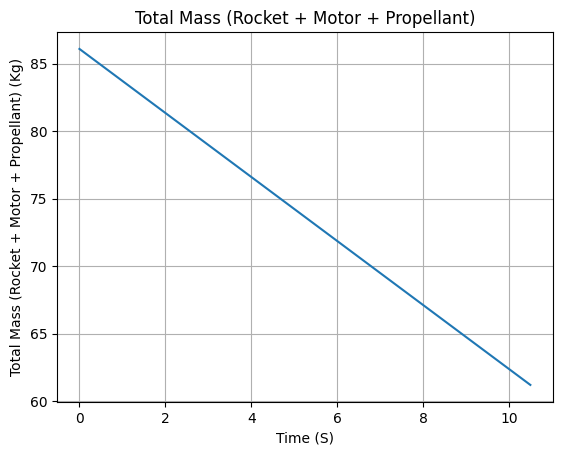

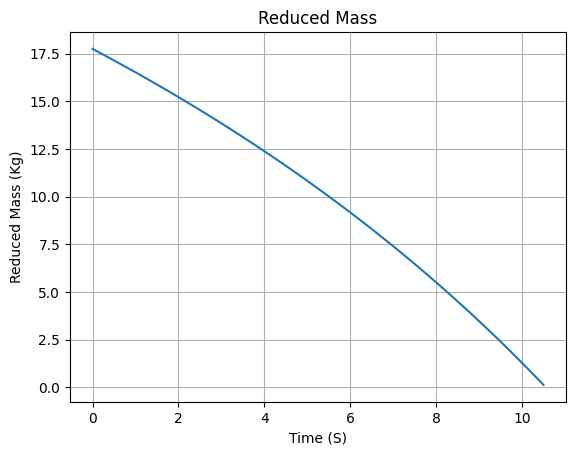


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


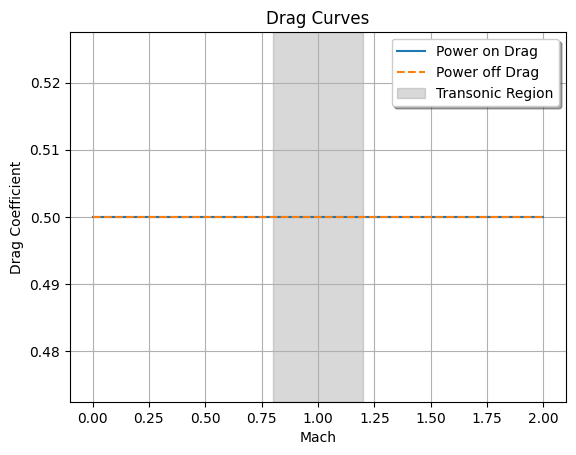


Stability Plots
--------------------


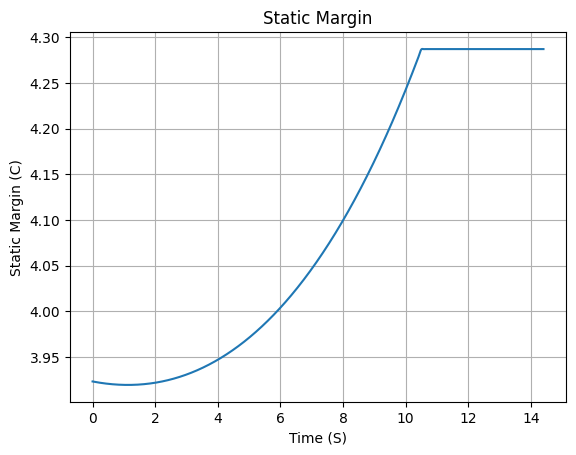

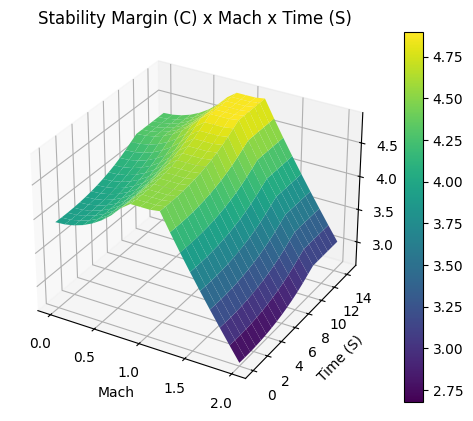


Thrust-to-Weight Plot
----------------------------------------


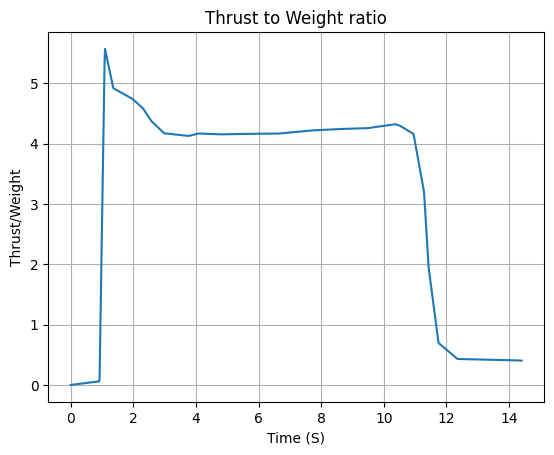


Maximum Values

Maximum Speed: 289.050 m/s at 11.40 s
Maximum Mach Number: 0.867 Mach at 11.43 s
Maximum Reynolds Number: 3.479e+06 at 11.33 s
Maximum Dynamic Pressure: 4.359e+04 Pa at 11.36 s
Maximum Acceleration During Motor Burn: 45.038 m/s² at 1.09 s
Maximum Gs During Motor Burn: 4.593 g at 1.09 s
Maximum Acceleration After Motor Burn: 23.106 m/s² at 10.07 s
Maximum Gs After Motor Burn: 2.356 Gs at 10.07 s
Maximum Stability Margin: 4.876 c at 10.54 s
Maximum Upper Rail Button Normal Force: 0.000 N
Maximum Upper Rail Button Shear Force: 0.000 N
Maximum Lower Rail Button Normal Force: 0.000 N
Maximum Lower Rail Button Shear Force: 0.000 N

Apogee State

Apogee Time: 35.143 s
Apogee Altitude: 4724.742 m (ASL) | 4724.742 m (AGL)
Apogee Freestream Speed: 37.834 m/s
Apogee X position: -17.845 m
Apogee Y position: 1286.720 m
Apogee latitude: 0.0115588°
Apogee longitude: -0.0001603°


In [10]:
from rocketpy import Rocket, Environment, Flight, LiquidMotor, Fluid, CylindricalTank, MassFlowRateBasedTank
from math import exp

# Define the environment
env = Environment() # Using Standard Atmosphere by default, 

# Define LiquidMotor

# Define fluids
# When it comes to N20, there is a problem that it's properties change with temperature, so it should be considered if the density shouldn't be given as a function of temperature

oxidizer_liq = Fluid(name="N2O_l", density=1220)
oxidizer_gas = Fluid(name="N2O_g", density=1.9277)
fuel_liq = Fluid(name="ethanol_l", density=789) 
fuel_gas = Fluid(name="ethanol_g", density=1.59)


# Define tanks geometry
# Here is the main problem in TRB the PV is a one tank divided by a piston, which is impossible to match 1 to 1 in rocketpy, so the precise simulation of the center of mass spot and stability margin can't be done, nevertheless the piston should increase rather then decrease the stability margin as it moves up away from the center of pressure.

fuel_tank = CylindricalTank(radius = 0.186, height = 0.25, spherical_caps = False) #I assume cylindrical shape with no spherical caps, as only one side will have them
oxidizer_tank = CylindricalTank(radius = 0.093, height = 0.83, spherical_caps = False)

# The data for the sizes comes from rocketpy, the problem is that inside the tanks are pipes that change the volumes, but here I will neglect that fact


# Define tanks
oxidizer_tank = MassFlowRateBasedTank(
    name="oxidizer tank",
    geometry=oxidizer_tank,
    flux_time=10.5, #From openrocket
    initial_liquid_mass=19, #Guess for now
    initial_gas_mass=0.01,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=19/10.5,
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=oxidizer_liq,
    gas=oxidizer_gas,
)

fuel_tank = MassFlowRateBasedTank(
    name="fuel tank",
    geometry=fuel_tank,
    flux_time=10.5,
    initial_liquid_mass=6,
    initial_gas_mass=0.01,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=6/10.5-0.01, #heuristics
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=lambda t: 0.01 / 10.5 * exp(-0.25 * t),
    liquid=fuel_liq,
    gas=fuel_gas,
)
# To sum up the tanks, they are just here to more or less correctly change the rocket mass, probably it should be based on the temperature, pressure functions over time with changing mass flow etc.

# Motor
# Thrust source from openrocket .eng file, dry mass it the mass of a motor plus empty tanks: 2.7(motor mass) + 16.6(PV) + 1.8(upper dome) + 1.8(bottom dome) + 2.2(piston mass)=25.1
z4000 = LiquidMotor(
    thrust_source=".\\data\\AGH-SS_Z4000-10sBurn-optimal.eng", #From tests
    dry_mass=25.1,
    dry_inertia=(8.46, 8.46, 0.2), #This should be calculated using CAD, here I use estimations, bad estimations
    nozzle_radius=0.0137, #From technical report
    center_of_dry_mass_position=1.33, #Estimated from openrocket
    nozzle_position=0,
    burn_time=14.4,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
z4000.add_tank(tank=oxidizer_tank, position=1.285) #From nozzle to center of the tank
z4000.add_tank(tank=fuel_tank, position=2.01)




# Rocket 
trb = Rocket(
    radius=0.1,
    mass=35.969, #All mass - engine mass and fuel
    inertia=(61.47, 61.47, 1.44), #Rough estimations, the correct values should be calculated from CAD
    power_off_drag=0.5,#".\\data\\cdmach.csv", #This should be taken from ansys or some other cfd simulation, here I use just some random data
    power_on_drag=0.5,#'.\\data\\cdmach.csv',
    center_of_mass_without_motor=2.43, #from openrocket
    coordinate_system_orientation="nose_to_tail", #Same as in openrocket
)

trb.add_motor(z4000, position=4.2)

nose_cone = trb.add_nose(
    length=0.7, kind="lvhaack", position=0
)

fin_set = trb.add_trapezoidal_fins(
    n=4,
    root_chord=0.287,
    tip_chord=0.059,
    span=0.202,
    sweep_length=0.228,
    position=4.21,
    cant_angle=0,
)

tail = trb.add_tail(
    top_radius=0.1, bottom_radius=0.065, length=0.287, position=4.21
)

rail_buttons = trb.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.6182,
    angular_position=45,
)

main = trb.add_parachute(
    name="main",
    cd_s=10,
    trigger=1000,      # ejection altitude in meters
    sampling_rate=105,
    lag=0,
    noise=(0, 8.3, 0.5),
    radius=2.25,
    height=2.25,
    porosity=0.0432,
)

drogue = trb.add_parachute(
    name="drogue",
    cd_s=0.8,
    trigger="apogee",  # ejection at apogee
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
    radius=0.76,
    height=0.76,
    porosity=0.0432,
)

test_flight = Flight(
    rocket=trb, environment=env, rail_length=10, inclination=85, heading=0
    )
trb.all_info()
test_flight.prints.maximum_values()
test_flight.prints.apogee_conditions()